In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
os.nice(1) 

1

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

In [5]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    bin_interp_points,
)

In [6]:
from datetime import datetime

In [7]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    get_spike_train_vector
)

In [8]:
from cdcp.spiketrain_analysis.unit_stats.cued_similarity_and_spikevector_differences import (
    compute_cued_average_sm_rv_differences
)

In [9]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [10]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [11]:
min_playbacks = 1000

In [12]:
import pandas as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter1d

from sklearn.metrics.pairwise import (
    cosine_similarity,
    euclidean_distances,
    manhattan_distances,
)

In [13]:
def get_unit_spike_trains(
    unit_recording_ids,
    spikesorting_folder,
    sorter,
    unit,
    bird,
    save_folder="trial_aligned_spikes",
):
    trial_aligned_spikes_list = []
    for unit, recording_id in tqdm(
        unit_recording_ids, desc="unit spike trains", leave=False, disable=True
    ):
        trial_aligned_spikes_loc = (
            DATA_DIR
            / "spikesorting"
            / save_folder
            / bird
            / recording_id
            / "{}.pickle.zip".format(unit)
        )
        if trial_aligned_spikes_loc.exists():
            trial_aligned_spikes = pd.read_pickle(trial_aligned_spikes_loc)
            trial_aligned_spikes["recording_id"] = recording_id

            trial_aligned_spikes["stim"] = [
                i[:-4] if i[-4:].lower() == ".wav" else i
                for i in trial_aligned_spikes.stim.values
            ]

            mask = [
                (i.split("_")[-1].isnumeric() and len(i.split("_")[-1]) == 3)
                for i in trial_aligned_spikes.stim.values
            ]

            # get cue info
            trial_aligned_spikes["cue"] = [
                i.split("_")[0] if mask else np.nan
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]
            trial_aligned_spikes["interp"] = [
                i.split("_")[1] if mask else np.nan
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]

            # for i, m in zip(trial_aligned_spikes.stim.values, mask):
            #    if m:
            #        int(i.split("_")[2])
            trial_aligned_spikes["interp_point"] = [
                np.nan if m == False else int(i.split("_")[2])
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]
            trial_aligned_spikes_list.append(trial_aligned_spikes)
        else:
            0
            # print("{} does not have trial aligned spikes yet".format(recording_id))
            # print("\t", trial_aligned_spikes_loc)
    if len(trial_aligned_spikes_list) < 1:
        #breakme
        return None
    else:
        return pd.concat(trial_aligned_spikes_list)

In [14]:
import copy
def equalize_samples_per_df(df1, df2, n_interp_point_bins = 16):
    for ip_bin in np.arange(n_interp_point_bins):
        n_valid = np.sum(df1.interp_point_binned == ip_bin)
        n_invalid = np.sum(df2.interp_point_binned == ip_bin)

        if n_valid > n_invalid:
            # sub sample valid
            m = np.ones(len(df1)).astype(bool)
            idx_to_remove = np.where(
                df1.interp_point_binned == ip_bin
            )[0][np.random.permutation(np.arange(n_valid))[: n_valid - n_invalid]]
            m[idx_to_remove] = False
            df1 = df1[m]
        elif n_invalid > n_valid:
            # sub sample invalid
            m = np.ones(len(df2)).astype(bool)
            idx_to_remove = np.where(
                df2.interp_point_binned == ip_bin
            )[0][np.random.permutation(np.arange(n_invalid))[: n_invalid - n_valid]]
            m[idx_to_remove] = False
            df2 = df2[m]

    return df1, df2

In [37]:
from sklearn import linear_model
import scipy.stats
from sklearn.metrics import confusion_matrix

from cdcp.spiketrain_analysis.spiketrain_utils import (
    bin_interp_points,
    get_average_response_vector,
    create_dense_similarity_matrix,
    get_similarity_matrix,
)
import copy

from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic


def compute_single_unit_decoder(
    trial_aligned_spikes,
    flip_bins=True,
    n_time_bins=100,
    n_interp_point_bins=16,
    mode="constant",
):
    os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"
    sm_dict = {}

    samplerate = 30000
    # ensure interp point is an integer
    trial_aligned_spikes["interp_point_binned"] = bin_interp_points(
        trial_aligned_spikes["interp_point"].values.astype(int),
        n_interp_point_bins,
        flip_bins=flip_bins,
    )

    # compute for each different interpolation
    for interp in trial_aligned_spikes.interp.unique():
        # get the spike vectors for the current interpolation
        spike_vector_trials_interp = trial_aligned_spikes[
            [
                "interp",
                "spike_vectors",
                "interp_point_binned",
                "correct",
                "cue",
                "passive",
                "recording_id",
                "frame_begin"
            ]
        ][trial_aligned_spikes.interp == interp]
        spike_vector_trials_interp = spike_vector_trials_interp.sort_values(
            by="interp_point_binned"
        )

        if len(spike_vector_trials_interp) == 0:
            continue
        
        recording_start_times = np.array([datetime.datetime.strptime('_'.join(i.split('_')[2:4]), 'dat%Y-%m-%d_%H-%M-%S') for i in spike_vector_trials_interp.recording_id.values])
        spike_vector_trials_interp['trial_time'] = [i+datetime.timedelta(seconds=j / samplerate) for i, j in zip(recording_start_times, spike_vector_trials_interp.frame_begin.values)]
        spike_vector_trials_interp['trial_hour'] = [i.astype('datetime64[h]').astype(int) % 24 for i in spike_vector_trials_interp.trial_time.values]
        spike_vector_trials_interp = spike_vector_trials_interp[spike_vector_trials_interp.trial_hour > 16]
        
        spike_vector_trials_interp_passive = spike_vector_trials_interp[
            spike_vector_trials_interp.passive == True
        ]
        
        spike_vector_trials_interp_train = spike_vector_trials_interp_passive[::2]
        spike_vector_trials_interp_test = spike_vector_trials_interp_passive[1::2]
        
        if len(spike_vector_trials_interp_train.interp_point_binned.unique()) < n_interp_point_bins:
            continue
        if len(spike_vector_trials_interp_test.interp_point_binned.unique()) < n_interp_point_bins:
            continue
        
        
        X_train = np.vstack(
            spike_vector_trials_interp_train.spike_vectors.values
        )
        y_train = spike_vector_trials_interp_train.interp_point_binned.values

        X_test = np.vstack(
            spike_vector_trials_interp_test.spike_vectors.values
        )
        y_test = spike_vector_trials_interp_test.interp_point_binned.values
        
        
        # Create an instance of the logistic regression classifier
        clf = linear_model.LogisticRegression(penalty="l2", class_weight='balanced')

        clf.fit(X_train, y_train)

        # get predictions
        train_predictions = clf.predict(X_train)

        test_predictions = clf.predict(X_test)

        spike_vector_trials_interp_test.trial_hour.values

        unique_hours = spike_vector_trials_interp_test.trial_hour.unique()
        hourly_acc = []
        for hour in unique_hours:
            m = spike_vector_trials_interp_test.trial_hour == hour
            hourly_acc.append(np.mean(test_predictions[m] == y_test[m]))
        
        sm_dict[f"{interp}_unique_hours"] = unique_hours
        sm_dict[f"{interp}_hourly_acc"] = hourly_acc
        
    return pd.Series(sm_dict)

### Compute spike vectors and statistics

In [23]:
n_time_bins = 100
identifier = "time_of_day"

In [24]:
def get_unit_statistic(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    bird,
    identifier=identifier,
    recompute=False,
    parallel=True,
    flip_bins=True,
    n_time_bins=100,
    gaussian_sigma_ms=25,
    save=True,
    plot=False,
):
    def run():
        
        unit_series_save_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.pickle".format(unit_to_analyze.cluster_id)
        )

        # check if we need to run everything
        if unit_series_save_loc.exists() and (recompute is False):
            print("stat already exists")
            return

        # make sure folder exists
        ensure_dir(unit_series_save_loc)

        unit_series_list = []
        # load spike trains
        trial_aligned_spikes = get_unit_spike_trains(
            unit_to_analyze.sort_units,
            spikesorting_folder,
            sorter,
            unit_to_analyze,
            bird=bird,
            save_folder="trial_aligned_spikes_padding_100ms",
        )
        if trial_aligned_spikes is None:
            # because there are not enough spikes for this unit to be worth it
            print("no trial_aligned_spikes")
            return

        # load spike train vectors
        spiketrain_vector_loc = (
            spikesorting_folder
            / "unit_statistics"
            / statistics_timestamp
            / "response_vector_25ms_{}".format(n_time_bins)
            / "{}.npy".format(unit_to_analyze.cluster_id)
        )

        if spiketrain_vector_loc.exists() == False:
            print("no spiketrains")
            return

        trial_aligned_spikes["spike_vectors"] = list(
            np.load(spiketrain_vector_loc, allow_pickle=True)
        )
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=Warning)
            statistic_series = compute_single_unit_decoder(
                trial_aligned_spikes,
                flip_bins=flip_bins,
                n_time_bins=n_time_bins,
                # n_interp_point_bins=n_interp_point_bins,
                mode="constant",
            )
        if statistic_series is not None:
            unit_series_list.append(statistic_series)

        # skip if no data is available
        if len(unit_series_list) == 0:
            return

        # save final row
        unit_series = pd.concat(unit_series_list)

        if save:
            unit_series.to_pickle(unit_series_save_loc)

        return unit_series

    if parallel == False:
        run()
    else:
        try:
            run()
        except Exception as e:
            with open("error_log.txt", "w") as text_file:
                text_file.write(str(e))
            raise ValueError(unit_to_analyze.cluster_id)

  0%|          | 0/10 [00:00<?, ?it/s]

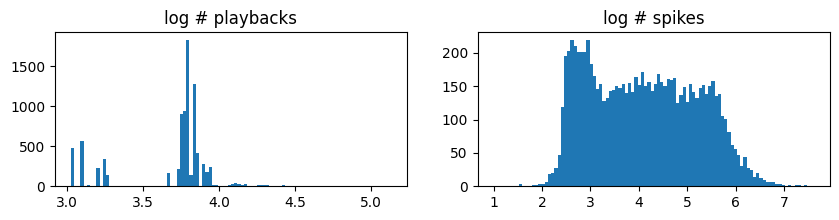

B1597 total # merged units: 8711


unit:   0%|          | 0/8711 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

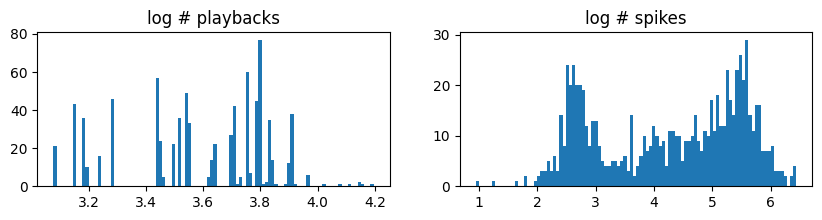

B1188 total # merged units: 821


unit:   0%|          | 0/821 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

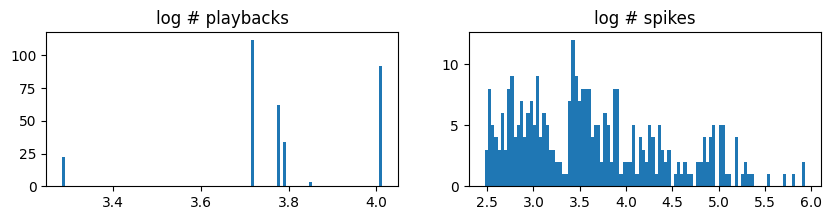

B1595 total # merged units: 325


unit:   0%|          | 0/325 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0675s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (4.9056s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   25.8s
[Parallel(n_j

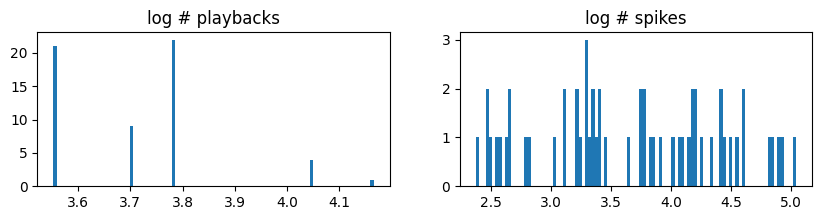

B1276 total # merged units: 57


unit:   0%|          | 0/57 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1774s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  24 out of  57 | elapsed:    2.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  30 out of  57 | elapsed:    6.0s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  36 out of  57 | elapsed:    6.9s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  42 out of  57 | elapsed:    8.3s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  48 out of  57 | elapsed:    9.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  54 out of  57 | elapsed:   11.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   11.2s finished


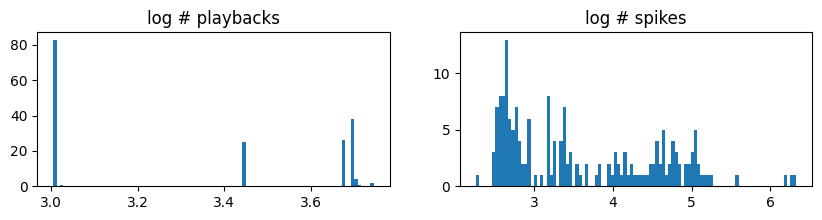

B1426 total # merged units: 180


unit:   0%|          | 0/180 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 160 out of 180 | elapsed:   19.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   20.3s finished


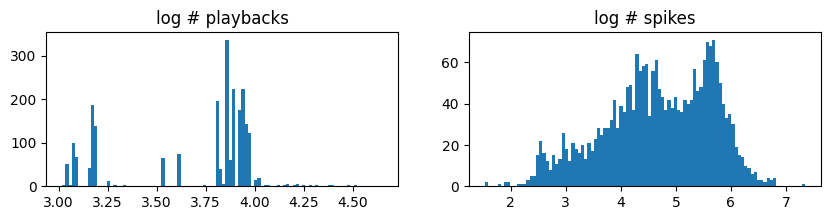

B1432 total # merged units: 2364


unit:   0%|          | 0/2364 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

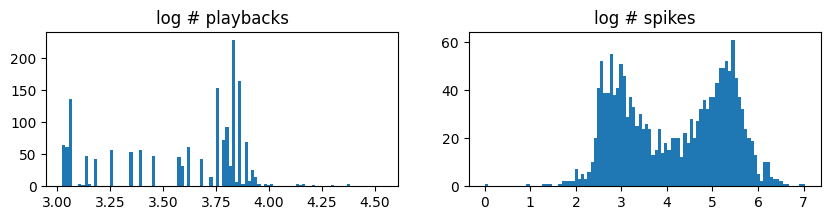

B1170 total # merged units: 1693


unit:   0%|          | 0/1693 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

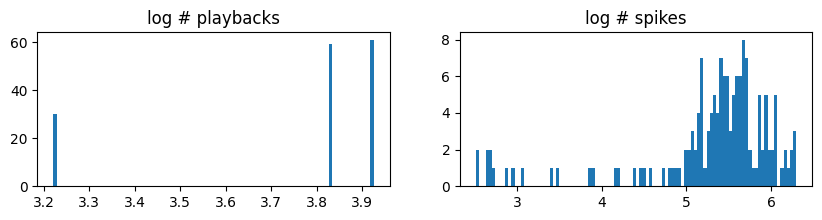

B1244 total # merged units: 150


unit:   0%|          | 0/150 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 127 out of 150 | elapsed:  1.1min remaining:   11.6s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:  1.1min remaining:    3.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


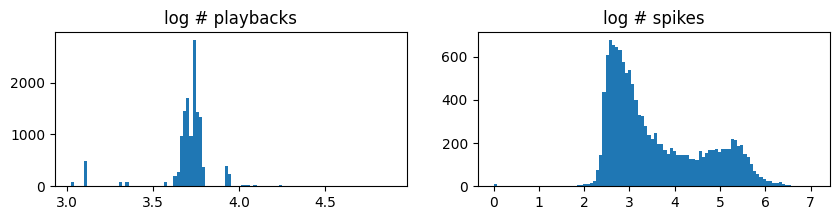

B1593 total # merged units: 13260


unit:   0%|          | 0/13260 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 7562 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 7685 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 7808 tasks      | elapsed: 14.6min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 7933 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 8058 tasks      | elapsed: 15.0min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 8185 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 8312 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 8441 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 8570 tasks      | elapsed: 15.6min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 8701 tasks      | elapsed: 15.8min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 8832 tasks      | elapsed: 16.0min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 8965 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 9098 tasks      | elapsed: 16.4min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 9233 tasks      | elapsed: 16.6min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 9368 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 9505 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 9642 tasks      | elapsed: 17.2min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 9781 tasks      | elapsed: 17.3min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 9920 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 10061 tasks      | elapsed: 17.6min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 10202 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 10345 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 10488 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 10633 tasks      | elapsed: 18.4min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 10778 tasks      | elapsed: 18.6min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 10925 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 11072 tasks      | elapsed: 19.0min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 11221 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 11370 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 11521 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 11672 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 11825 tasks      | elapsed: 20.0min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 11978 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 12133 tasks      | elapsed: 20.6min


no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned_spikes
no trial_aligned

[Parallel(n_jobs=-1)]: Done 12288 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 12445 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 12602 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1784s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1848s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 12766 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1980s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 13260 out of 13260 | elapsed: 21.2min finished


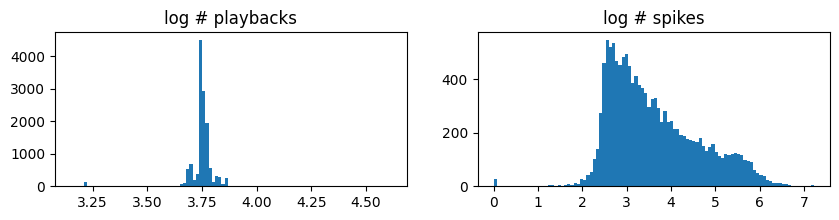

B1248 total # merged units: 13184


unit:   0%|          | 0/13184 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

In [ ]:
for bird, timestamp, sorter in tqdm(birds):
    spikesorting_folder = (DATA_DIR
                / "spikesorting"
                / bird
                / timestamp)
    # get the summary of recordings for the bird
    recording_summary_df = pd.read_pickle(
        DATA_DIR / "spikesorting" / "recording_df" / f"{bird}.pickle.zip"
    )

    # get units that are to be merged
    merged_units = pd.read_pickle(
            DATA_DIR / "spikesorting" / "unit_clusters" / f"{bird}.pickle.zip"
        )
    merged_units = merged_units.sort_values(by='n_playbacks', ascending=False)
    merged_units = merged_units[merged_units.n_playbacks.astype('float')  > min_playbacks]
    
    plot = True
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10,2))
        axs[0].hist(np.log10(merged_units.n_playbacks.values.astype('float')+1), bins = 100);
        axs[0].set_title('log # playbacks')
        axs[1].hist(np.log10(merged_units.n_spikes.values.astype('float')+1), bins = 100);
        axs[1].set_title('log # spikes')
        plt.show()
        print('{} total # merged units: {}'.format(bird, len(merged_units)))
    
    ensure_dir(spikesorting_folder / 'unit_statistics' / statistics_timestamp)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=Warning)
        Parallel(n_jobs = -1, verbose=10)(
            delayed(get_unit_statistic)(
                unit_to_analyze,
                spikesorting_folder,
                statistics_timestamp,
                bird = bird,
                recompute=True,
                parallel=True,
                n_time_bins = n_time_bins

                        )
            for uniti, unit_to_analyze in tqdm(
                merged_units.iterrows(), desc="unit", total=len(merged_units)
            )
        );

### Debugging

In [29]:
breakme

NameError: name 'breakme' is not defined

In [38]:
for uniti, unit_to_analyze in tqdm(
        merged_units[:]
        .iterrows(), desc="unit", total=len(merged_units)
    ):
    if unit_to_analyze.cluster_id != 89:
        continue
    break

unit:   0%|          | 0/8711 [00:00<?, ?it/s]

In [39]:
unit_series = get_unit_statistic(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    bird=bird,
    recompute=True,
    parallel=False,
    save=False,
    plot=False,
)

### make dataframe

In [ ]:
ensure_dir(DATA_DIR / 'unit_statistics' / statistics_timestamp / identifier)

In [ ]:
def read_and_unit(i):
    try:
        df = pd.read_pickle(i)
        df['unit'] = i.stem
        return df
    except:
        return

In [ ]:
for bird, timestamp, sorter in tqdm(birds):
    print(bird)
    spikesorting_folder = (DATA_DIR
                / "spikesorting"
                / bird
                / timestamp)
    # get the summary of recordings for the bird
    recording_summary_df = pd.read_pickle(
        DATA_DIR / "spikesorting" / "recording_df" / f"{bird}.pickle.zip"
    )
    unit_series_save_loc = (
        spikesorting_folder / "unit_statistics" / statistics_timestamp / identifier
    )
    unit_pickles = list(unit_series_save_loc.glob("*.pickle"))
    if len(unit_pickles) == 0:
        print('\t no units')
        continue
    unit_statistics_df = pd.concat(
        Parallel(n_jobs=-1, prefer="threads")(
            delayed(read_and_unit)(i)
            for i in tqdm(unit_pickles, leave=False, desc="reading pickles")
        ),
        axis=1,
    ).T

    unit_statistics_df.to_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
    